<a href="https://colab.research.google.com/github/cfong32/netflix-prize/blob/main/step3_torch_sgd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# download preprocessed dataset
# !wget -qO ratings_M50.csv https://uoguelphca-my.sharepoint.com/:x:/g/personal/chungyan_uoguelph_ca/EWqG6YIAGfpLihYVvtpMeRQB1ngfhPZPydHCoUL87QR3yA?download=1
# !wget -qO ratings_M1000.csv https://uoguelphca-my.sharepoint.com/:x:/g/personal/chungyan_uoguelph_ca/ESYy4ukVKs9DkY6-YVBh-0kBr5uQE29dC1Tq0PRi_tJJhg?download=1
!wget -qO ratings_M18000.csv https://uoguelphca-my.sharepoint.com/:x:/g/personal/chungyan_uoguelph_ca/Ee327xnlX-tMtxTqmlanh4wBh3aDQAtFemy4CaJ_PraDTQ?download=1

In [ ]:
# # uncomment to prepare to save model to your google drive
# from google.colab import drive
# drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
pd.set_option('display.min_rows', 4)

# check GPU
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
print('device:', device)

device: cuda


In [ ]:
# read dataset into dataframe

df = (pd.read_csv('ratings_M18000.csv')
      .assign(target=lambda x: x.rating/6)
)
N = df.user.nunique()
M = df.movie.nunique()

print('num_user:', N, 'num_movie:', M)
display(df)

num_user: 480189 num_movie: 17770


,user,movie,rating,target
0,0,0,3,0.500000
1,1,0,5,0.833333
...,...,...,...,...
100480505,22793,17769,4,0.666667
100480506,76269,17769,2,0.333333


In [ ]:
# split data into train and test sets

max_test_split = 0.2
max_test_num = 100_000

test  = df.sample(frac=min(max_test_num/len(df), max_test_split))
train = df[~df.index.isin(test.index)]

display(train)
display(test)

,user,movie,rating,target
0,0,0,3,0.500000
1,1,0,5,0.833333
...,...,...,...,...
100480505,22793,17769,4,0.666667
100480506,76269,17769,2,0.333333


,user,movie,rating,target
41133895,46499,7248,3,0.500000
49925973,150773,8988,3,0.500000
...,...,...,...,...
19537951,56352,3727,3,0.500000
93595258,37939,16603,4,0.666667


In [ ]:
# build the matrix-multiplication-based model

class MatrixMultiplicationModel(nn.Module):
    def __init__(self, num_user, num_movie, emb_dim):
        super().__init__()
        self.U = nn.Embedding(num_user, emb_dim)    # matrix U, user embeddings, sized N-by-D
        self.V = nn.Embedding(num_movie, emb_dim)   # matrix V, movie embeddings, sized M-by-D
        
    def forward(self, um_idxs):
        u_idx, m_idx = um_idxs[:,0].int(), um_idxs[:,1].int()
        U = self.U(u_idx)                           # retrieve user embeddings by user indexes
        V = self.V(m_idx)                           # retrieve movie embeddings by movie indexes
        dot_products = (U*V).sum(dim=1)             # predicted ratings are their dot products
        # output = torch.sigmoid(dot_products)      # map to [0,1]
        output = dot_products
        return output

In [ ]:
# set hyperparameters
D = 10              # embedding dimension
lr = 1e-3           # learning rate
batch_size = 1024
max_epoch = 10
patience = 10       # early stop if not improving in this num of evaluations

# convert data to torch datasets and dataloaders
train_um_idx = torch.IntTensor  (train[['user', 'movie']].values).to(device)
train_y      = torch.FloatTensor(train.target.values).to(device)
train_size   = len(train_um_idx)
train_ds     = TensorDataset(train_um_idx, train_y)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last=True)

test_um_idx  = torch.IntTensor  (test[['user', 'movie']].values).to(device)
test_y       = torch.FloatTensor(test.target.values).to(device)

# initialize model and ...
model = MatrixMultiplicationModel(num_user =N,
                                  num_movie=M,
                                  emb_dim  =D).to(device)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# train
recs = []
min_test_loss = None
i_batch = 0
for epoch in range(max_epoch):

    # gradient descent
    model.train()
    for batch_um_idx, batch_y in train_loader:
        optimizer.zero_grad()
        train_y_hat = model(batch_um_idx)
        loss = loss_fn(train_y_hat, batch_y)
        loss.backward()
        optimizer.step()

        # evaluate test loss
        if i_batch % 1000 == 0:
            model.eval()
            test_y_hat = model(test_um_idx)
            test_loss = loss_fn(test_y_hat, test_y).item()
            rec = {
                'epoch'     : epoch,
                'batch'     : i_batch,
                'train_loss': loss.item(),
                'test_loss' : test_loss,
            }
            recs.append(rec)
            print(rec)

            # # uncomment to save checkpoint to your google drive
            # torch.save({
            #     'recs': recs,
            #     'model_state_dict': model.state_dict(),
            #     'optimizer_state_dict': optimizer.state_dict(),
            # }, '/gdrive/MyDrive/Shared/M17000.ckpt')

            # check for early stopping
            if min_test_loss is None or test_loss < min_test_loss:
                min_test_loss = test_loss
                not_improving_count = 0
            else:
                not_improving_count += 1
                if not_improving_count >= patience:
                    break
        i_batch += 1

{'epoch': 0, 'batch': 0, 'train_loss': 10.513419151306152, 'test_loss': 10.216348648071289}
{'epoch': 0, 'batch': 1000, 'train_loss': 7.811773300170898, 'test_loss': 7.336317539215088}
{'epoch': 0, 'batch': 2000, 'train_loss': 4.755890846252441, 'test_loss': 5.334234714508057}
{'epoch': 0, 'batch': 3000, 'train_loss': 3.769062042236328, 'test_loss': 3.9547154903411865}
{'epoch': 0, 'batch': 4000, 'train_loss': 2.856962203979492, 'test_loss': 3.0040605068206787}
{'epoch': 0, 'batch': 5000, 'train_loss': 2.265958547592163, 'test_loss': 2.3527016639709473}
{'epoch': 0, 'batch': 6000, 'train_loss': 1.722359538078308, 'test_loss': 1.905185580253601}
{'epoch': 0, 'batch': 7000, 'train_loss': 1.6528044939041138, 'test_loss': 1.592366099357605}
{'epoch': 0, 'batch': 8000, 'train_loss': 1.392547845840454, 'test_loss': 1.3698614835739136}
{'epoch': 0, 'batch': 9000, 'train_loss': 1.3125015497207642, 'test_loss': 1.206047773361206}
{'epoch': 0, 'batch': 10000, 'train_loss': 0.976109504699707, 'te

<Axes: xlabel='batch'>

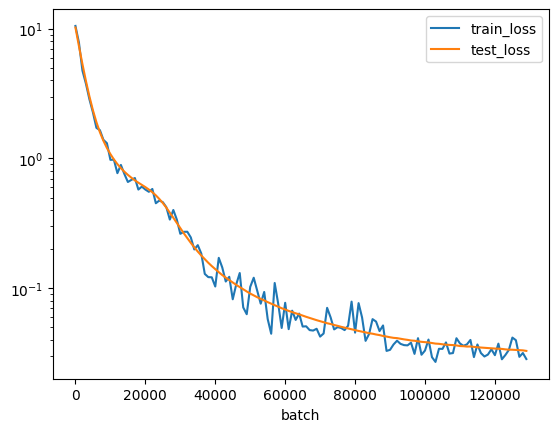

In [ ]:
# training curves
pd.DataFrame(recs).set_index('batch')[['train_loss', 'test_loss']].plot(logy=True)

In [ ]:
# resulted U and V
U = model.U.weight
V = model.V.weight

print('first few rows of,')
print('U:', U[:3])
print('V:', V[:3])

first few rows of,
U: tensor([[ 0.0769,  0.6942,  0.1779,  0.6189, -0.3053, -0.1750, -0.7518,  0.5507,
          0.2701, -0.3216],
        [ 1.0119,  1.0063,  1.5439, -0.6961, -2.9968,  1.4796,  0.2930, -0.1219,
          0.5526, -0.9587],
        [ 0.0659,  0.6468,  0.9000,  0.8209,  0.2548,  0.3707, -0.4268,  1.2460,
          0.0871, -2.0986]], device='cuda:0', grad_fn=<SliceBackward0>)
V: tensor([[ 0.1505,  0.1436,  0.0843,  0.0688, -0.1676, -0.1759, -0.1666,  0.1146,
          0.1587, -0.0910],
        [-0.3413,  0.0691,  0.4789,  0.5024,  0.2889, -0.2561, -0.3767,  0.6689,
          0.1454, -0.6356],
        [ 0.1301,  0.1683,  0.1603,  0.1004, -0.1223, -0.1150, -0.1708,  0.0993,
          0.1299, -0.1110]], device='cuda:0', grad_fn=<SliceBackward0>)


In [ ]:
# prediction results

test_y_hat = model(test_um_idx).cpu().detach().numpy()

df_res = (
    test
    .assign(target_pred    =test_y_hat,
            rating_pred    =lambda x: (x.target_pred*6).clip(1,5),  # clipped between 1 and 5
            rating_residual=lambda x: x.rating - x.rating_pred)
)

df_res.sample(10)

,user,movie,rating,target,target_pred,rating_pred,rating_residual
19966172,100424,3823,4,0.666667,0.672910,4.037459,-0.037459
12352516,61758,2375,4,0.666667,0.674573,4.047436,-0.047436
69203041,37364,12537,3,0.500000,0.522051,3.132304,-0.132304
25021155,130153,4660,2,0.333333,0.569303,3.415816,-1.415816
51362550,81950,9292,3,0.500000,0.499201,2.995204,0.004796
47203196,17833,8496,3,0.500000,0.557951,3.347707,-0.347707
74319676,208665,13461,3,0.500000,0.554491,3.326946,-0.326946
53826442,51425,9785,5,0.833333,0.824302,4.945811,0.054189
10311824,243019,1999,3,0.500000,0.503528,3.021169,-0.021169
89721006,74279,15944,3,0.500000,0.580290,3.481743,-0.481743


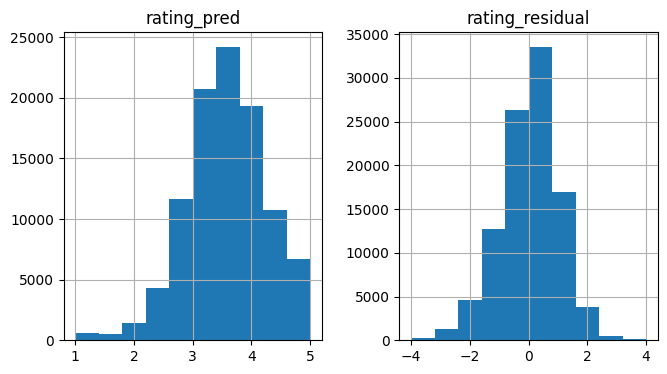

In [ ]:
# distribution of residuals
df_res[['rating_pred', 'rating_residual']].hist(figsize=(12,4), layout=(1,3))
plt.show()